<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI285 - Computación Científica I / INF285 - Computación Científica</h1>
    <h1> New Tarea 3: Missing values  </h1>
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
<center>Agosto 2019 - v1.01 </center>
</p>

---

## Nombre: Juan Pablo Javier León León
## ROL: 201473047-0
## Email: juan.leonl.14@sansano.usm.cl

In [159]:
from __future__ import print_function
import numpy as np
#pip3 install imutils
import imutils
#pip3 install opencv-python
import cv2 
import scipy.interpolate as scp
import random
from timeit import default_timer
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

## Contexto

Luego de haber demostrado las habilidades de los estudiantes de Computación Científica en la tarea 1 y 2,
el SCT 2019 les encarga una nueva tarea: experimentar con métodos de interpolación 1D para rellenar _missing values_ en imagenes.

# Problema

Se desea rellenar un cuadrado, de lado $n$, de _missing values_ (valores _NaN_ perdidos de la imagen original) presentes en imagenes de diversos tipos usando interpolación en $1D$.

Suponga se tiene una imagen representada por una matriz de dimensiones $H$x$W$. Para un cuadrado de _missing values_ de tamaño $n < H,W$, donde la esquina superior izquierda del mismo está ubicado en la posición $(x_{hole}, y_{hole})$ de la matriz , se puede interpolar utilizando todos los valores distintos de _NaN_  de la fila $x_{hole}$ o columna $y_{hole}$ y utilizar el polinomio generado para rellenar los puntos que faltan de la misma fila/columna, y repetir este procedimiento para cada fila $i$ con $x_{hole} < i < x_{hole} + n$, o para cada columna $j$ con $ y_{hole} < j < y_{hole} + n$, hasta rellenar todos los _missing values_. Para ilustrar lo anterior, considere que se tiene la siguiente imagen con _missing values_:

<img src="example_2.png" style="float:center;height:200px">

La idea es utilizar la información de los pixeles presentes en la imagen para encontrar una aproximación de los _missing values_, e insertarlos en la imagen. Esto se puede realizar _fila a fila_ (tomando cada linea de pixeles horizontal y utilizar la _data_ presente para rellenar los _missing values_ de esa linea), _columna a columna_, o algún método híbrido entre ambos. El resultado ideal es el siguiente:

<img src="example_1.png" style="float:center;height:200px">

Para cargar una imagen a una matriz de tamaño _height_ x _width_, donde cada elemento $a_{ij}$ corresponde al código en escala de grises del pixel _ij_, puede usar la siguiente función. 

In [11]:
'''
src_name: path of the image.
'''
def image_to_matrix(src_name):
    # Se lee el video
    stream = cv2.imread(src_name,0)
    print("Tamanio imagen", stream.shape)
    return stream

def write_image(img, title):
    cv2.imwrite(title,img)
    
ej = image_to_matrix("example_1.png")
# organizada por columnas


Tamanio imagen (334, 500)


Por simplicidad de la dimensión de la matriz resultante, se cargaran las imagenes en escala de grises en lugar de usar colores. También se adjunta una función para escribir una matriz a una imagen de nombre _title_.

Para generar un cuadrado de _missing values_ en una posición aleatoria dentro de la imagen ya cargada, se usa la siguiente función.

In [12]:
'''
function to make a hole on the image matrix. 

image: array representation of image
size: size of the hole (>= 2)
seed: seed of the pseudo-random generator.
case: "center" for making a hole inside the image (default)
      "border" for making a hole on any border
      "corner" for making a hole on any corner

      
Returns a copy of the image with a hole, and the coordinates of the upper left corner of the hole
'''
def make_a_hole(image, size, seed, case="center"):
    random.seed(seed)
    h, w = image.shape
    if case == "center":
        x_hole,y_hole = random.randint(1, h - size - 1), random.randint(1, w - size - 1)
    elif case == "border":
        if random.choice([0,1]) == 0: 
            x_hole,y_hole = random.randint(1, h - size - 1), random.choice([0, w - size])
        else:
             x_hole,y_hole = random.choice([0, h - size]),random.randint(1, w - size - 1)
    elif case == "corner":
        position = random.choice([0,1,2,3]) 
        if position == 0:
            x_hole,y_hole = 0, 0
        elif position == 1:
            x_hole,y_hole = 0, w - size
        elif position == 2:
            x_hole,y_hole = h - size, 0
        elif position == 3:
            x_hole,y_hole = h - size, w - size
            
    aux = np.array(image,copy=True)
    aux[x_hole:x_hole+size, y_hole:y_hole+size] = np.nan
    
    return aux, x_hole,y_hole

### 1. Elección de método de interpolación

En primer lugar, se compararán diversos métodos de interpolación para interpolar y rellenar _missing values_. 

Encuentre, experimentalmente, la complejidad de la interpolación usando :
1. Método de Lagrange
2. Método de Lagrange Baricéntrico
3. _KroghInterpolator_ [1]
4. _CubicSpline_ [2]
5. _interp1d_ [3]
    
Para esto, realice un _log-log plot_ del **tiempo de cómputo de construcción del interpolador** para cada método _vs_ $n$ (tamaño del vector de la _data_ $(x,y)$, y encuentre la pendiente (orden del algoritmo) de la recta obtenida. Realice este análisis tomando un vector aleatorio $x$ de tamaño $n$ variable, donde $x_i \in [0,1]$, e interpole la función $f(x) = \sin(2\pi x)$ a modo de prueba, mediante un polinomio utilizando los métodos descritos anteriormente. Use la semilla propuesta a continuación.
    
 

   Grafique todas las curvas en el mismo plano para realizar la comparación. Concluya respecto al análisis anterior y, en base a esto, seleccione un método de interpolación adecuado para el resto de la tarea.

In [13]:
random.seed(3)            
puntos = [[],[]]
N = 250

for i in range(N):
    x = random.random()
    puntos[0].append(x)

puntos[0].sort()
    
for j in range(N):
    y = np.sin(2*np.pi*puntos[0][j])
    puntos[1].append(y)

In [15]:
# Tiempos Lagrange

tiemposL = [] 

for j in range(10, N):
    start = default_timer()
    poly = scp.lagrange(puntos[0][0:j], puntos[1][0:j])
    tiemposL.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposL)

In [16]:
# Tiempos Lagrange Baricentrica

tiemposB = []

for j in range(10,N):
    start = default_timer()
    poly = scp.BarycentricInterpolator(puntos[0][0:j], puntos[1][0:j])
    tiemposB.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposB)

In [17]:
# Tiempos Kroghinterpolator

tiemposK = []

for j in range(10, N):
    start = default_timer()
    poly = scp.KroghInterpolator(puntos[0][0:j], puntos[1][0:j])
    tiemposK.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposK)

In [18]:
# Tiempos CubiSpline

tiemposC = []

for j in range(10,N):
    start = default_timer()
    poly = scp.CubicSpline(puntos[0][0:j], puntos[1][0:j])
    tiemposC.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposC)


In [19]:
# Tiempos interp1d

tiemposI = []

for j in range(10,N):
    start = default_timer()
    poly = scp.interp1d(puntos[0][0:j], puntos[1][0:j])
    tiemposI.append(default_timer()-start)
    #if j % 10 == 0: print(j)
#print(tiemposI)

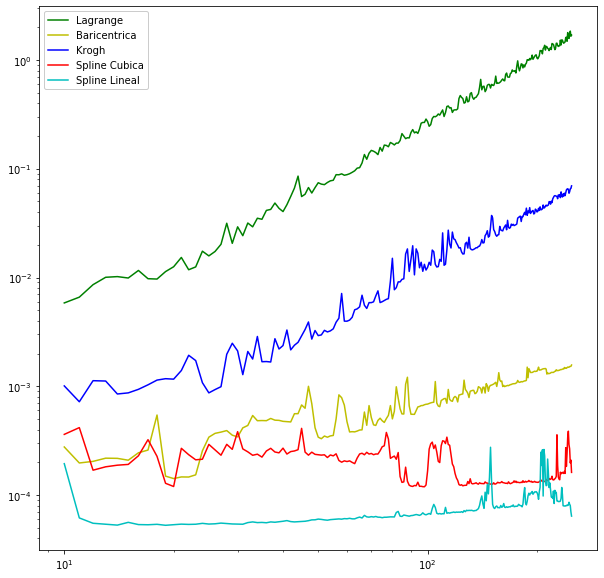

In [29]:
# LogLog plot

n = range(10,N)

fig= plt.figure(figsize=(10,10))
plt.loglog(n, tiemposL, 'g', label='Lagrange') 
plt.loglog(n, tiemposB, 'y', label='Baricentrica')
plt.loglog(n, tiemposK,  'b', label='Krogh')
plt.loglog(n, tiemposC, 'r', label='Spline Cubica')
plt.loglog(n, tiemposI, 'c', label='Spline Lineal')
plt.legend(framealpha=1, frameon=True);
plt.show()

Como se puede observar, _interp1d_ tiene el menor tiempo de ejecución casi siempre, seguido de _CubicSpline_ por lo que consideramos que estos dos método son los mejores candidatos. A continuación dejamos los valores de las pendientes de las rectas anteriores:

In [35]:
pendienteL = np.polyfit(np.log(n), np.log(tiemposL), 1)[0]
pendienteB = np.polyfit(np.log(n), np.log(tiemposB), 1)[0]
pendienteK = np.polyfit(np.log(n), np.log(tiemposK), 1)[0]
pendienteC = np.polyfit(np.log(n), np.log(tiemposC), 1)[0]
pendienteI = np.polyfit(np.log(n), np.log(tiemposI), 1)[0]

print("Pendiente recta de tiempo método de Lagrange: " + str(pendienteL))
print("Pendiente recta de tiempo método Lagrange Baricéntrica: " + str(pendienteB))
print("Pendiente recta de tiempo método de Krogh: " + str(pendienteK))
print("Pendiente recta de tiempo método de Spline Cúbica: " + str(pendienteC))
print("Pendiente recta de tiempo método de Spline Lineal: " + str(pendienteI))

Pendiente recta de tiempo método de Lagrange: 1.9016036441681774
Pendiente recta de tiempo método Lagrange Baricéntrica: 0.6860724460502043
Pendiente recta de tiempo método de Krogh: 1.6083508047231434
Pendiente recta de tiempo método de Spline Cúbica: -0.243289055066398
Pendiente recta de tiempo método de Spline Lineal: 0.25484977368465983


Como podemos observar, las menores pendientes calzan con nuestras suposiciones anteriores. Complementando con la información del gráfico podemos ver que el método con _interp1d_ es más estable que _CubicSpline_, por lo que lo escogemos para la siguiente pregunta.

### 2. Elección de Heurística (Dirección de la interpolación)

Utilizando el método de interpolación seleccionado:

* Implemente la función `fill_hole_bidirectional` que rellene _missing values_ ordenados en un cuadrado de lado _size_ en una imagen utilizando interpolación vertical (es decir, rellenando columna a columna), interpolación horizontal (rellenando fila a fila), o del tipo _average_ (tomando el promedio de ambas interpolaciones). 


In [120]:
'''
function to fill a hole on the image matrix. 

image: array representation of image
x_hole,y_hole: coordinates of the hole
size: size of the hole (>= 2)
interpolator: function for interpolation.
direction: "h" for horizontal interpolation
            "v" for vertical interpolation
            "a" for average interpolation

'''

def fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, direction):
    height, width = image.shape
    
    if not(isinstance(size, int)) or size < 2:
        raise Exception("size must be an integer value >= 2. The value of size was: {}".format(size))
    
    # interpolacion horizontal
    if direction == 'h':
        xValues = []
        xValues.extend(range(0, y_hole))
        xValues.extend(range(y_hole + size, width))
        fv = np.nan
        
        # caso hole en bordes eje y
        if( y_hole == 0 or y_hole == width - size): fv="extrapolate"
        
        for j in range(x_hole, x_hole + size):
            
            yValues = []
            
            for i in range(0, y_hole):
                
                yValues.append(image[j][i])
            
            for i in range(y_hole + size, width):
                
                yValues.append(image[j][i])
            
            poly = interpolator(xValues, yValues, fill_value=fv)
            for i in range(y_hole, y_hole + size):
                image[j][i] = poly(i)    
            

    # interpolacion vertical
    elif direction == 'v':
        xValues = [] 
        xValues.extend(range(0, x_hole))
        xValues.extend(range(x_hole + size, height))
        fv = np.nan
        
        # caso hole en bordes eje x
        if( x_hole == 0 or x_hole == height - size): fv="extrapolate"
        
        for i in range(y_hole, y_hole + size):
            yValues = []
            
            for j in range(0, x_hole):
                yValues.append(image[j][i])
                
            for j in range(x_hole + size, height):
                yValues.append(image[j][i])
            
            poly = interpolator(xValues, yValues, fill_value=fv)
            for j in range(x_hole, x_hole + size):
                 image[j][i] = poly(j)
                    
       
    # promedio entre ambas interpolaciones
    elif direction == 'a':
        # primer interpolacion horizontal
        for j in range(x_hole, x_hole + size):
            xValues = []
            yValues = []
            fv = np.nan
        
            # caso hole en bordes eje y
            if( y_hole == 0 or y_hole == width - size): fv="extrapolate"
            
            for i in range(0, y_hole):
                xValues.append(i)
                yValues.append(image[j][i])
            
            for i in range(y_hole + size, width):
                xValues.append(i)
                yValues.append(image[j][i])
            
            polyH = interpolator(xValues, yValues, fill_value=fv)
            for i in range(y_hole, y_hole + size):
                image[j][i] = polyH(i)/2
        
        # luego itnerpolacion vertical
        for i in range(y_hole, y_hole + size):
            xValues = []
            yValues = []
            fv = np.nan
        
            # caso hole en bordes eje x
            if( x_hole == 0 or x_hole == height - size): fv="extrapolate"
                
            for j in range(0, x_hole):
                xValues.append(j)
                yValues.append(image[j][i])
                
            for j in range(x_hole + size, height):
                xValues.append(j)
                yValues.append(image[j][i])
            
            polyV = interpolator(xValues, yValues, fill_value=fv)
            for j in range(x_hole, x_hole + size):
                image[j][i] += polyV(j)/2
    
                
    else:
        raise Exception("direction should either be 'h', 'v' or 'a'. The value of direction was: {}".format(direction))
    return image



In [134]:
# para probra el codigo
seed = random.seed(10)

# caso horizontal
ej1 = image_to_matrix("example_1.png")
ej11, x_hole1, y_hole1 = make_a_hole(ej1, 80, seed, case="corner")
print(x_hole1, y_hole1)
write_image(ej11, 'ej11.png')

app1 = fill_hole_bidirectional(ej11, x_hole1, y_hole1, 80, scp.interp1d, 'a')
write_image(app1, 'app1.png')

# caso vertical

ej2 = image_to_matrix("example_1.png")
ej22, x_hole2, y_hole2 = make_a_hole(ej2, 80, seed, case="border")
print(x_hole2, y_hole2)
write_image(ej22, 'ej22.png')
app2 = fill_hole_bidirectional(ej22, x_hole2, y_hole2, 80, scp.interp1d, 'a')
write_image(app2, 'app2.png')

# caso promedio

ej3 = image_to_matrix("example_1.png")
ej33, x_hole3, y_hole3 = make_a_hole(ej3, 80, seed, case="center")
print(x_hole3, y_hole3)
write_image(ej33, 'ej33.png')

app3 = fill_hole_bidirectional(ej33, x_hole3, y_hole3, 80, scp.interp1d, 'a')
write_image(app3, 'app3.png')

Tamanio imagen (334, 500)
254 0
Tamanio imagen (334, 500)
110 0
Tamanio imagen (334, 500)
219 403


* Realice los siguientes tests:
  * Test de Rendimiento: Tiempo de cómputo del algoritmo
  * Test de Calidad de la interpolación resultante (Error matricial): Norma de Frobenius del error; es decir, sea $I$ la sección cuadrada $[x_{hole}, y_{hole}] \times [x_{hole} + n, y_{hole} + n]$ de la imagen original (sin _missing values_), y $R$ la misma sección cuadrada de la imagen reconstruida/interpolada: 
  
  $$
  || I - R ||_2 = \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} |I_{ij} - R_{ij} |^2}
  $$
  
  Usando las imagenes de gradientes _v_gradient.png_, _h_gradient.jpg_ y _d_gradient.png_ con los 3 tipos de interpolación mencionados (_horizontal_, _vertical_ y _average_). Considere que los _missing values_ están en el interior de la imagen, i.e centrales. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Realice un análisis cualitativo, graficando las imagenes resultantes y comparandolas con la imagen original. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

In [192]:
#test with h_gradient
image = image_to_matrix("imagenes/h_gradient.png")
#guardamos la matriz que vamos a aproximar
write_image(image, 'h_gradient.png')
size = 300
img_center_hole,x_hole,y_hole = make_a_hole(image, size, seed=30, case="center")


#... interpolation using fill_hole_bidirectional and analisis
start1 = default_timer()
img_center_hole_app_h = fill_hole_bidirectional(img_center_hole, x_hole, y_hole, size, scp.interp1d, 'h')
finish1 = default_timer()-start1
write_image(img_center_hole_app_h, "img_center_hole_app_h.png")

start2 = default_timer()
img_center_hole_app_v = fill_hole_bidirectional(img_center_hole, x_hole, y_hole, size, scp.interp1d, 'v')
finish2 = default_timer()-start2
write_image(img_center_hole_app_v, "img_center_hole_app_v.png")

start3 = default_timer()
img_center_hole_app_a = fill_hole_bidirectional(img_center_hole, x_hole, y_hole, size, scp.interp1d, 'a')
finish3 = default_timer()-start3
write_image(img_center_hole_app_a, "img_center_hole_app_a.png")


#test with v_gradient
image2 = image_to_matrix("imagenes/v_gradient.png")
#guardamos la matriz que vamos a aproximar
write_image(image2, 'v_gradient.png')
size2 = 300
img2_center_hole,x_hole2,y_hole2 = make_a_hole(image2, size2, seed=30, case="center")

#... interpolation using fill_hole_bidirectional
start4 = default_timer()
img2_center_hole_app_h = fill_hole_bidirectional(img2_center_hole, x_hole2, y_hole2, size2, scp.interp1d, 'h')
finish4 = default_timer()-start4
write_image(img2_center_hole_app_h, "img2_center_hole_app_h.png")

start5 = default_timer()
img2_center_hole_app_v = fill_hole_bidirectional(img2_center_hole, x_hole2, y_hole2, size2, scp.interp1d, 'v')
finish5 = default_timer()-start5
write_image(img2_center_hole_app_v, "img2_center_hole_app_v.png")

start6 = default_timer()
img2_center_hole_app_a = fill_hole_bidirectional(img2_center_hole, x_hole2, y_hole2, size2, scp.interp1d, 'a')
finish6 = default_timer()-start6
write_image(img2_center_hole_app_a, "img2_center_hole_app_a.png")

#test with d_gradient
image3 = image_to_matrix("imagenes/d_gradient.png")
#guardamos la matriz que vamos a aproximar
write_image(image3, 'd_gradient.png')
size3 = 300
img3_center_hole,x_hole3,y_hole3 = make_a_hole(image3, size3, seed=30, case="center")

#... interpolation using fill_hole_bidirectional 
start7 = default_timer()
img3_center_hole_app_h = fill_hole_bidirectional(img3_center_hole, x_hole3, y_hole3, size3, scp.interp1d, 'h')
finish7 = default_timer()-start7
write_image(img3_center_hole_app_h, "img3_center_hole_app_h.png")

start8 = default_timer()
img3_center_hole_app_v = fill_hole_bidirectional(img3_center_hole, x_hole3, y_hole3, size3, scp.interp1d, 'v')
finish8 = default_timer()-start8
write_image(img3_center_hole_app_v, "img3_center_hole_app_v.png")

start9 = default_timer()
img3_center_hole_app_a = fill_hole_bidirectional(img3_center_hole, x_hole3, y_hole3, size3, scp.interp1d, 'a')
finish9 = default_timer()-start9
write_image(img3_center_hole_app_a, "img3_center_hole_app_a.png")

Tamanio imagen (2000, 2400)
Tamanio imagen (2400, 2000)
Tamanio imagen (2000, 2400)


In [184]:
def error(m1, m2):
    x_size, y_size = m1.shape
    sub_abs_cua = 0
    
    for i in range(x_size):
        for j in range(y_size):
            sub_abs_cua += (np.absolute(float(m1[i][j]) - float(m2[i][j]))**2)
    return np.sqrt(sub_abs_cua)

Imagen de gradiente horizontal a aproximar


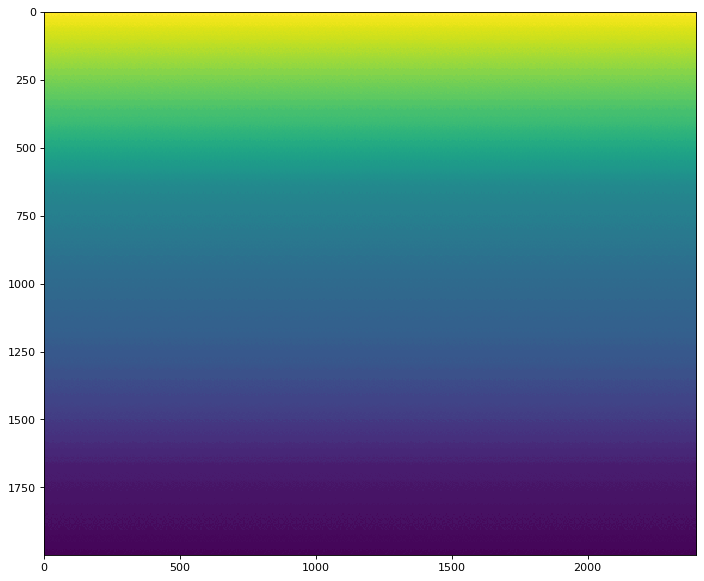

Aproximación de la imagen de gradiente horizontal con spline lineal horizontal
Error = 437.7556395981667
Tiempo de ejecución: 3.7305113000002166


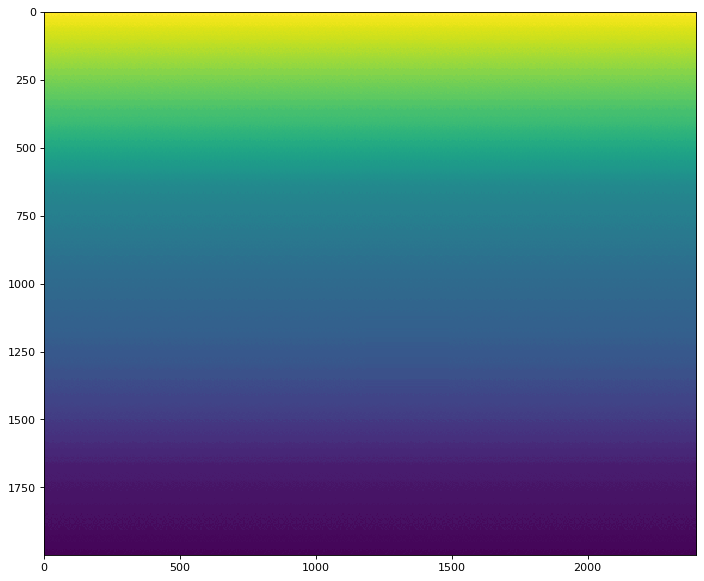

Aproximación de la imagen de gradiente horizontal con spline lineal vertical
Error = 437.7556395981667
Tiempo de ejecución: 3.7128755999983696


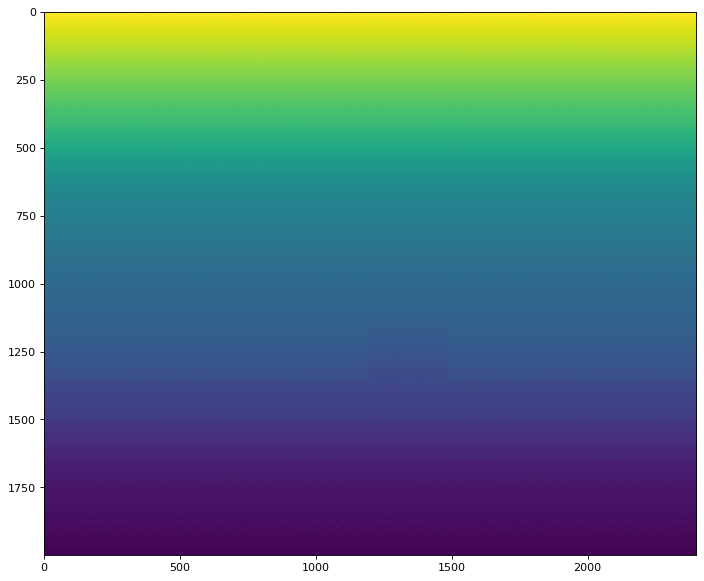

Aproximación de la imagen de gradiente horizontal con spline lineal promedio
Error = 437.7556395981667
Tiempo de ejecución: 7.7228276999994705


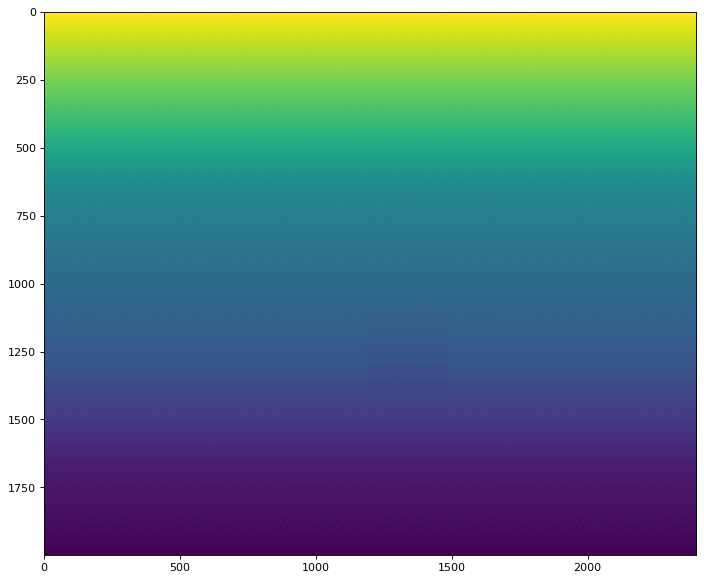

Imagen de gradiente vertical a aproximar


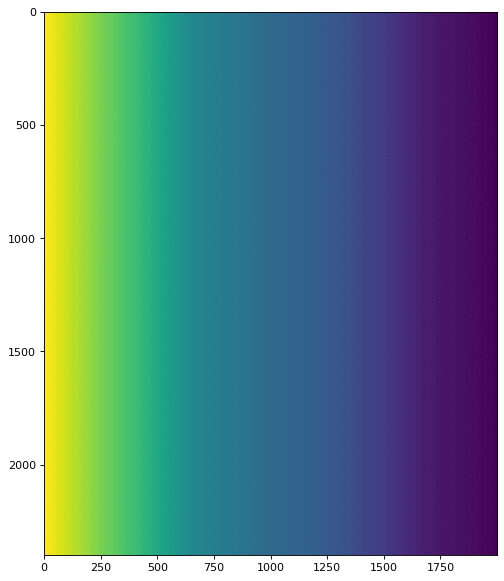

Aproximación de la imagen de gradiente vertical con spline lineal horizontal
Error = 381.45641952915145
Tiempo de ejecución: 3.4936033000012685


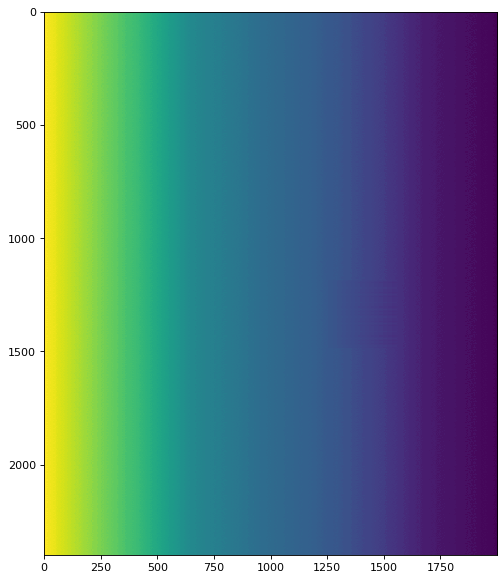

Aproximación de la imagen de gradiente vertical con spline lineal vertical
Error = 381.45641952915145
Tiempo de ejecución: 3.501174199998786


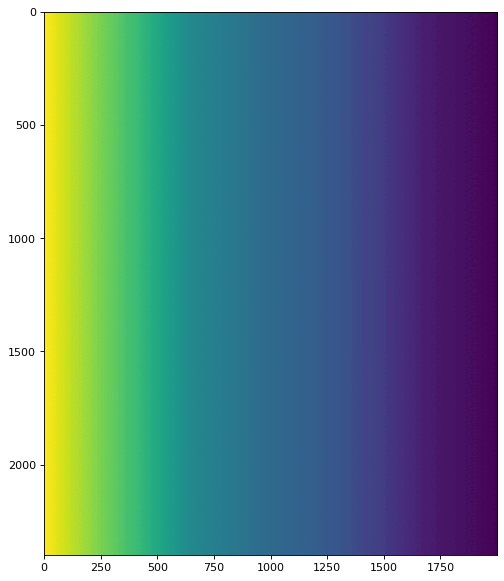

Aproximación de la imagen de gradiente vertical con spline lineal promedio
Error = 381.45641952915145
Tiempo de ejecución: 8.749758899997687


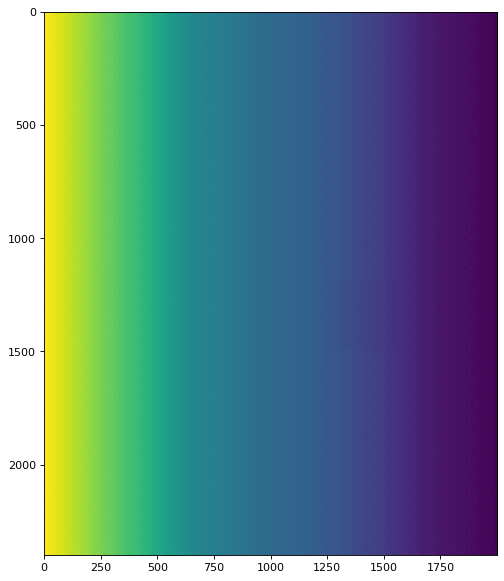

Imagen de gradiente diagonal a aproximar


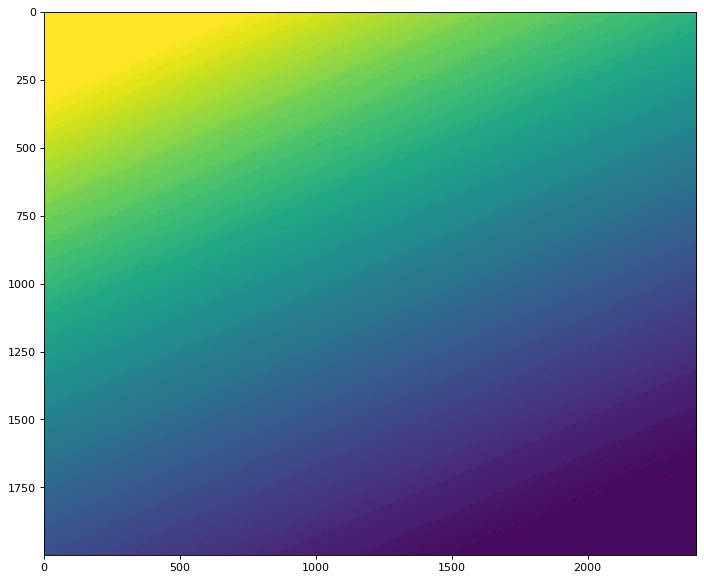

Aproximación de la imagen de gradiente diagonal con spline lineal horizontal
Error = 341.53037932225004
Tiempo de ejecución: 3.7191463000017393


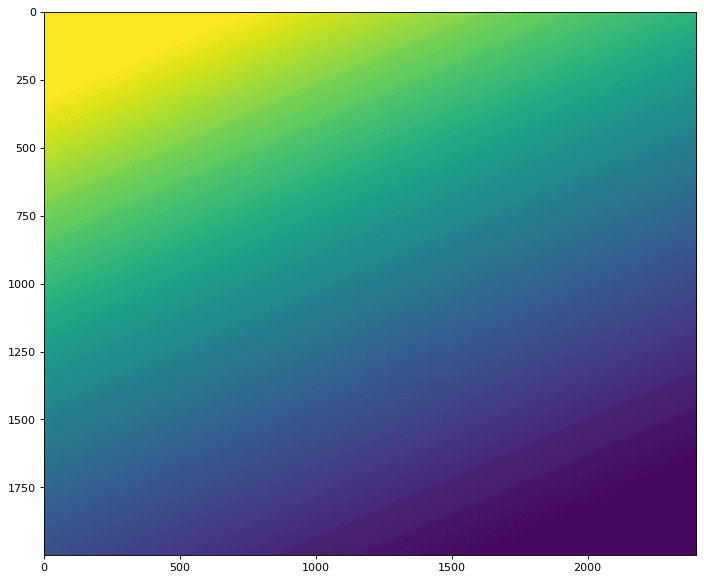

Aproximación de la imagen de gradiente diagonal con spline lineal vertical
Error = 341.53037932225004
Tiempo de ejecución: 3.4578202000011515


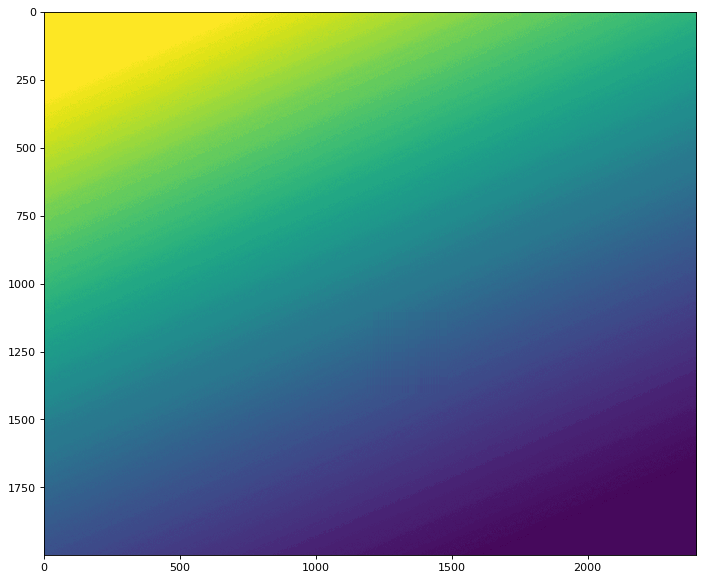

Aproximación de la imagen de gradiente diagonal con spline lineal promedio
Error = 341.53037932225004
Tiempo de ejecución: 7.880715499999496


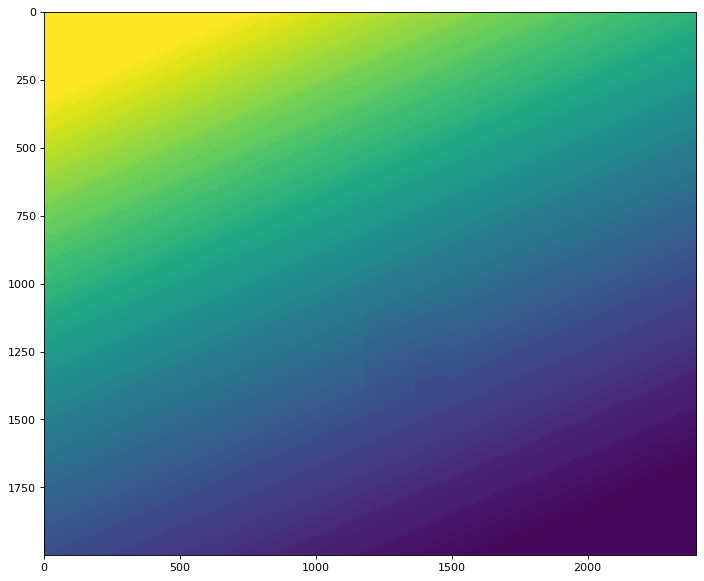

In [193]:
# calculo norma de Frobenius h_gradient
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
img_app_h_subm = img_center_hole_app_h[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
img_app_v_subm = img_center_hole_app_v[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
img_app_a_subm = img_center_hole_app_a[x_hole:x_hole+size-1, y_hole:y_hole+size-1]

error_center_hole_app_h = error(img_subm,img_app_h_subm)
error_center_hole_app_v = error(img_subm,img_app_v_subm)
error_center_hole_app_a = error(img_subm,img_app_a_subm)

print("Imagen de gradiente horizontal a aproximar")
figure(num=1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('h_gradient.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()


figure(num=2, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente horizontal con spline lineal horizontal")
print("Error = " + str(error_center_hole_app_h))
print("Tiempo de ejecución: " + str(finish1))
img_h_gradient_app_h = mpimg.imread('img_center_hole_app_h.png')
imgplot = plt.imshow(img_h_gradient_app_h)
plt.show()


figure(num=3, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente horizontal con spline lineal vertical")
print("Error = " + str(error_center_hole_app_v))
print("Tiempo de ejecución: " + str(finish2))
img_h_gradient_app_v = mpimg.imread('img_center_hole_app_v.png')
imgplot = plt.imshow(img_h_gradient_app_v)
plt.show()


figure(num=4, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente horizontal con spline lineal promedio")
print("Error = " + str(error_center_hole_app_a))
print("Tiempo de ejecución: " + str(finish3))
img_h_gradient_app_a = mpimg.imread('img_center_hole_app_a.png')
imgplot = plt.imshow(img_h_gradient_app_a)
plt.show()

# calculo norma de Frobenius v_gradient
img2_subm = image2[x_hole2:x_hole2+size2-1, y_hole2:y_hole2+size2-1]
img2_app_h_subm = img2_center_hole_app_h[x_hole2:x_hole2+size2-1, y_hole2:y_hole2+size2-1]
img2_app_v_subm = img2_center_hole_app_v[x_hole2:x_hole2+size2-1, y_hole2:y_hole2+size2-1]
img2_app_a_subm = img2_center_hole_app_a[x_hole2:x_hole2+size2-1, y_hole2:y_hole2+size2-1]

error2_center_hole_app_h = error(img2_subm,img2_app_h_subm)
error2_center_hole_app_v = error(img2_subm,img2_app_v_subm)
error2_center_hole_app_a = error(img2_subm,img2_app_a_subm)

print("Imagen de gradiente vertical a aproximar")
figure(num=5, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
img_v_gradient = mpimg.imread('v_gradient.png')
imgplot = plt.imshow(img_v_gradient)
plt.show()


figure(num=6, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente vertical con spline lineal horizontal")
print("Error = " + str(error2_center_hole_app_h))
print("Tiempo de ejecución: " + str(finish4))
img_v_gradient_app_h = mpimg.imread('img2_center_hole_app_h.png')
imgplot = plt.imshow(img_v_gradient_app_h)
plt.show()


figure(num=7, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente vertical con spline lineal vertical")
print("Error = " + str(error2_center_hole_app_v))
print("Tiempo de ejecución: " + str(finish5))
img_v_gradient_app_v = mpimg.imread('img2_center_hole_app_v.png')
imgplot = plt.imshow(img_v_gradient_app_v)
plt.show()


figure(num=8, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente vertical con spline lineal promedio")
print("Error = " + str(error2_center_hole_app_a))
print("Tiempo de ejecución: " + str(finish6))
img_v_gradient_app_a = mpimg.imread('img2_center_hole_app_a.png')
imgplot = plt.imshow(img_v_gradient_app_a)
plt.show()

# calculo norma de Frobenius d_gradient
img3_subm = image3[x_hole3:x_hole3+size3-1, y_hole3:y_hole3+size3-1]
img3_app_h_subm = img3_center_hole_app_h[x_hole3:x_hole3+size3-1, y_hole3:y_hole3+size3-1]
img3_app_v_subm = img3_center_hole_app_v[x_hole3:x_hole3+size3-1, y_hole3:y_hole3+size3-1]
img3_app_a_subm = img3_center_hole_app_a[x_hole3:x_hole3+size3-1, y_hole3:y_hole3+size3-1]

error3_center_hole_app_h = error(img3_subm,img3_app_h_subm)
error3_center_hole_app_v = error(img3_subm,img3_app_v_subm)
error3_center_hole_app_a = error(img3_subm,img3_app_a_subm)

print("Imagen de gradiente diagonal a aproximar")
figure(num=9, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
img_d_gradient = mpimg.imread('d_gradient.png')
imgplot = plt.imshow(img_d_gradient)
plt.show()


figure(num=10, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente diagonal con spline lineal horizontal")
print("Error = " + str(error3_center_hole_app_h))
print("Tiempo de ejecución: " + str(finish7))
img_d_gradient_app_h = mpimg.imread('img3_center_hole_app_h.png')
imgplot = plt.imshow(img_d_gradient_app_h)
plt.show()


figure(num=11, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente diagonal con spline lineal vertical")
print("Error = " + str(error3_center_hole_app_v))
print("Tiempo de ejecución: " + str(finish8))
img_d_gradient_app_v = mpimg.imread('img3_center_hole_app_v.png')
imgplot = plt.imshow(img_d_gradient_app_v)
plt.show()


figure(num=12, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print("Aproximación de la imagen de gradiente diagonal con spline lineal promedio")
print("Error = " + str(error3_center_hole_app_a))
print("Tiempo de ejecución: " + str(finish9))
img_d_gradient_app_a = mpimg.imread('img3_center_hole_app_a.png')
imgplot = plt.imshow(img_d_gradient_app_a)
plt.show()

### Análisis Cualitativo
A simple vista, para una imagen cuyos pixeles siguen un patrón horizontal/vertical la mejor opción es realizar interpolación horizontal/vertical, a pesar de que den los mismos errores, posiblemente debido a que la diferencia en la interpolación que sigue la orientación de la imagen es menos perceptible por el ojo humano. No se aprecia mayor diferencia en los distintos métodos para una imagen orientada diagonalmente.

   

* Realice el mismo análisis anterior, pero rellenando _missing values_ presentes en los bordes de la imagen. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

Tamanio imagen (2000, 2400)
Segmento Top Hole imagen gradiente horizontal a aproximar


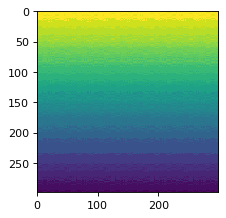

Segmento aproximado con spline lineal horizontal
Error = 175.9232787325202


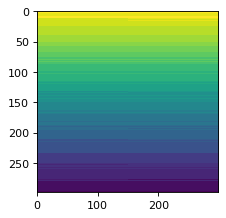

Segmento aproximado con spline lineal vertical
Error = 22219.104932467464


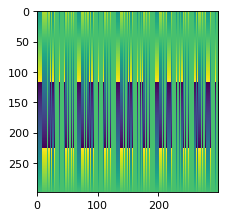

Segmento aproximado con spline lineal promedio
Error = 26437.122630876456


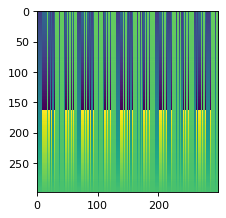

In [217]:
#test with h_gradient, top hole
image = image_to_matrix("imagenes/h_gradient.png")
size=300
img_top_hole,x_hole,y_hole = make_a_hole(image, size, seed=30, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Hole imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()


Segmento Right Hole imagen gradiente horizontal a aproximar


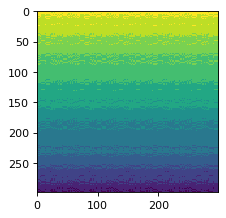

Segmento aproximado con spline lineal horizontal
Error = 10426.760235087408


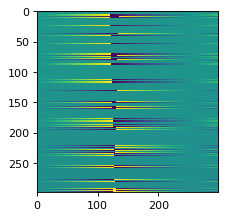

Segmento aproximado con spline lineal vertical
Error = 315.9968354271922


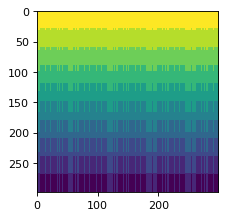

Segmento aproximado con spline lineal promedio
Error = 12337.981520491916


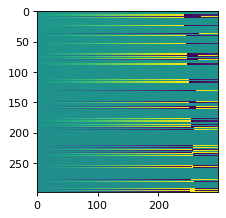

In [218]:
# test with h_gradient, right hole

img_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=100, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Right Hole imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Left Hole imagen gradiente horizontal a aproximar


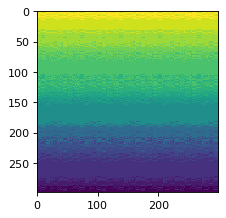

Segmento aproximado con spline lineal horizontal
Error = 12154.182037471712


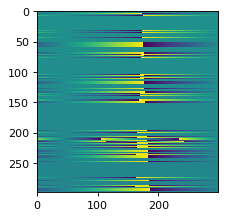

Segmento aproximado con spline lineal vertical
Error = 371.80371165441585


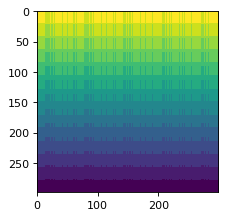

Segmento aproximado con spline lineal promedio
Error = 14229.185043423955


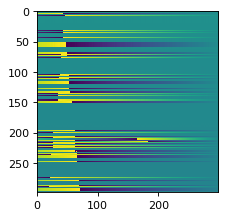

In [219]:
# test with h_gradient, left hole

img_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Left Hole imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Bottom Hole imagen gradiente horizontal a aproximar


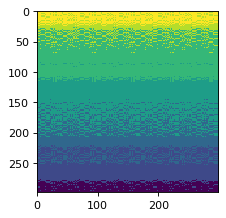

Segmento aproximado con spline lineal horizontal
Error = 233.67498796405232


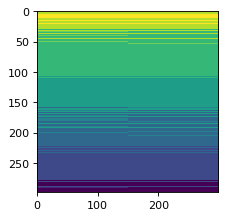

Segmento aproximado con spline lineal vertical
Error = 5898.468190979756


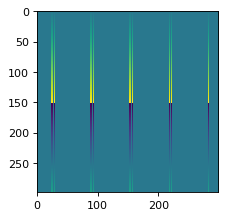

Segmento aproximado con spline lineal promedio
Error = 6866.16464993376


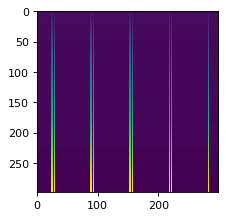

In [220]:
# test with h_gradient, bottom hole

img_bottom_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Hole imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2400, 2000)
Segmento Top Hole imagen gradiente vertical a aproximar


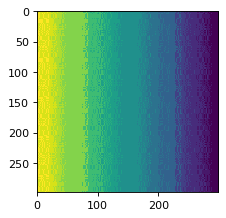

Segmento aproximado con spline lineal horizontal
Error = 321.0389384482823


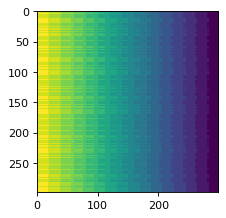

Segmento aproximado con spline lineal vertical
Error = 13026.826935213348


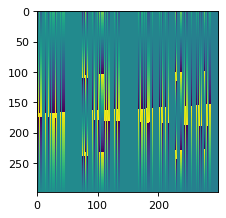

Segmento aproximado con spline lineal promedio
Error = 15085.420710076336


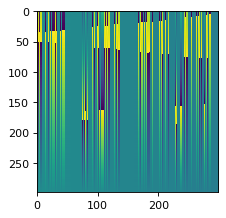

In [221]:
#test with v_gradient, top hole

image = image_to_matrix("imagenes/v_gradient.png")
size=300
img_top_hole,x_hole,y_hole = make_a_hole(image, size, seed=30, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Hole imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()


Segmento Right Hole imagen gradiente vertical a aproximar


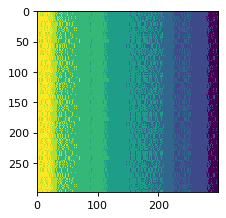

Segmento aproximado con spline lineal horizontal
Error = 5316.745809233314


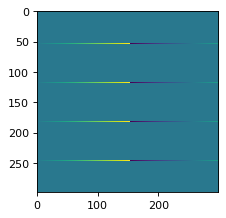

Segmento aproximado con spline lineal vertical
Error = 218.2292372712694


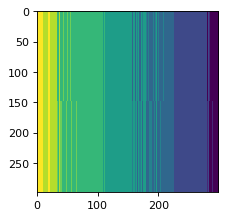

Segmento aproximado con spline lineal promedio
Error = 6147.568218409618


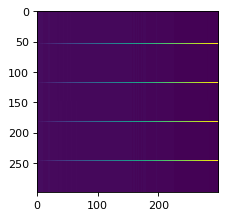

In [222]:
# test with v_gradient, right hole

img_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=100, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Right Hole imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Left Hole imagen gradiente vertical a aproximar


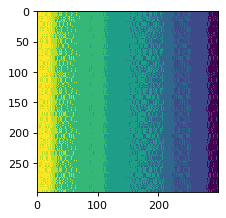

Segmento aproximado con spline lineal horizontal
Error = 5898.42563740529


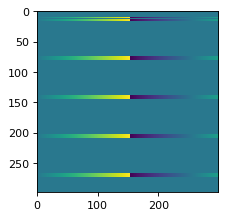

Segmento aproximado con spline lineal vertical
Error = 226.66715686221505


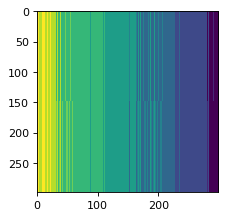

Segmento aproximado con spline lineal promedio
Error = 6863.798729566594


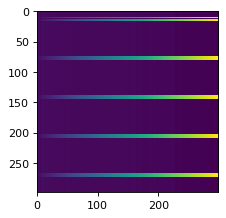

In [223]:
# test with v_gradient, left hole

img_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Left Hole imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Bottom Hole imagen gradiente vertical a aproximar


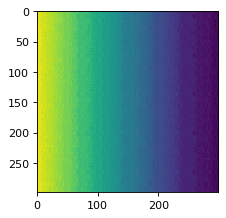

Segmento aproximado con spline lineal horizontal
Error = 462.6316028980294


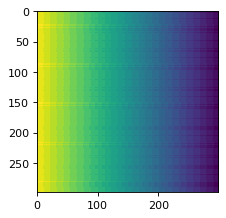

Segmento aproximado con spline lineal vertical
Error = 13733.06389703332


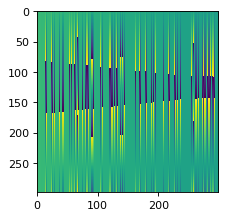

Segmento aproximado con spline lineal promedio
Error = 16119.48007846407


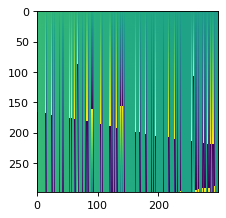

In [224]:
# test with v_gradient, bottom hole

img_bottom_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Hole imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Top Hole imagen gradiente diagonal a aproximar


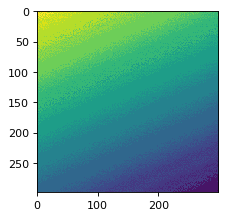

Segmento aproximado con spline lineal horizontal
Error = 242.64377181374346


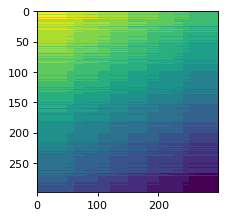

Segmento aproximado con spline lineal vertical
Error = 18013.504267632103


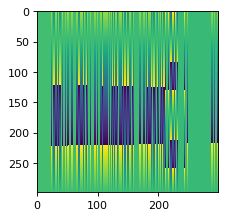

Segmento aproximado con spline lineal promedio
Error = 21198.54308673122


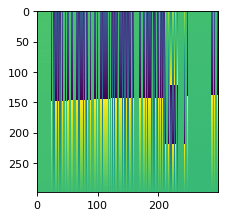

In [225]:
# test with d_gradient, top hole

image = image_to_matrix("imagenes/d_gradient.png")
size=300
img_top_hole,x_hole,y_hole = make_a_hole(image, size, seed=30, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Hole imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_hole_app = fill_hole_bidirectional(img_top_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_hole_app = error(img_subm,img_app_subm)

figure(num=3, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()


Segmento Right Hole imagen gradiente diagonal a aproximar


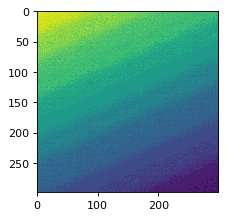

Segmento aproximado con spline lineal horizontal
Error = 12209.038905663296


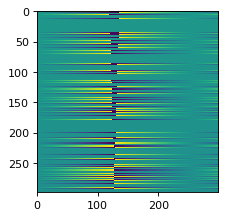

Segmento aproximado con spline lineal vertical
Error = 229.12005586591496


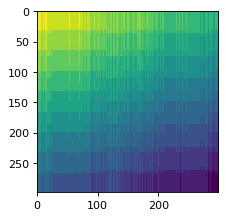

Segmento aproximado con spline lineal promedio
Error = 14426.445612138841


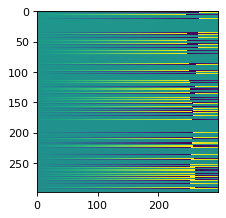

In [226]:
# test with d_gradient, right hole

img_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=100, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Right Hole imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_right_hole_app = fill_hole_bidirectional(img_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Left Hole imagen gradiente diagonal a aproximar


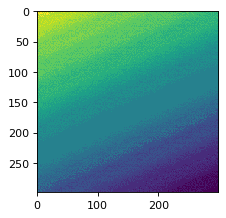

Segmento aproximado con spline lineal horizontal
Error = 15746.492212553245


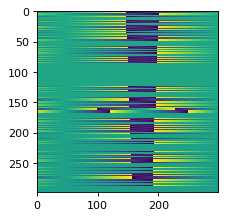

Segmento aproximado con spline lineal vertical
Error = 290.1827010695159


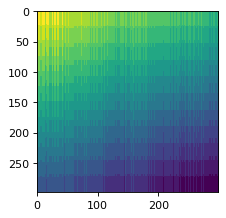

Segmento aproximado con spline lineal promedio
Error = 18850.973157903547


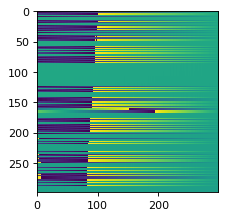

In [227]:
# test with d_gradient, left hole

img_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Left Hole imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_left_hole_app = fill_hole_bidirectional(img_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Segmento Bottom Hole imagen gradiente diagonal a aproximar


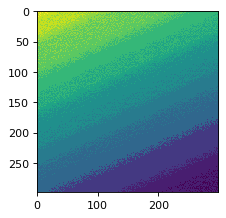

Segmento aproximado con spline lineal horizontal
Error = 251.00796800101784


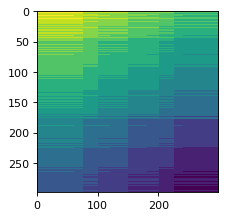

Segmento aproximado con spline lineal vertical
Error = 13542.317711529293


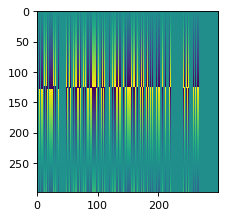

Segmento aproximado con spline lineal promedio
Error = 16024.521334504816


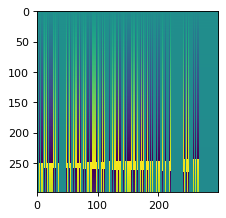

In [228]:
# test with d_gradiant, bottom hole

img_bottom_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="border")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Hole imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

# h
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_hole_app = fill_hole_bidirectional(img_bottom_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

### Análisis Cualitativo
Para este caso, debido al problema de tener que encontrar valores fuera de nuestra interpolación es que lo mejor es escoger un método que no requiera extrapolar. Para imágenes que tienen agujeros en lado izquierdo y derecho lo mejor es hacer una interpolación vertical, mientras que para imágenes que tienen agujeros en el lado superior e inferior lo mejor es hacer interpolación horizontal.

* Realice el mismo análisis anterior, pero rellenando _missing values_ presentes en las esquinas de la imagen. Realice los análisis para cada imagen generada utilizando los parámetros siguientes para `make_a_hole`. Argumente y concluya, basandose en ecuaciones, la elección de uno de los 3 tipos de interpolación para estos casos. Incluya otro tipo de métrica de comparación si lo considera necesario.

Tamanio imagen (2000, 2400)
Segmento Bottom Left imagen gradiente horizontal a aproximar


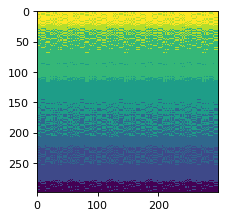

Segmento aproximado con spline lineal horizontal
Error = 12412.270098575844


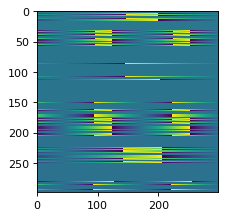

Segmento aproximado con spline lineal vertical
Error = 5898.443608274983


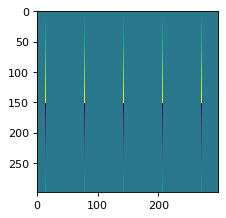

Segmento aproximado con spline lineal promedio
Error = 14446.454201637162


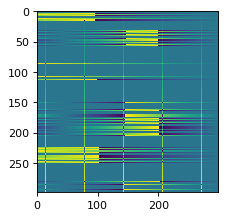

In [229]:
# test with h_gradient, bottom left hole

image = image_to_matrix("imagenes/h_gradient.png")
size=300
img_bottom_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Left imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()


Tamanio imagen (2000, 2400)
Segmento Top Left imagen gradiente horizontal a aproximar


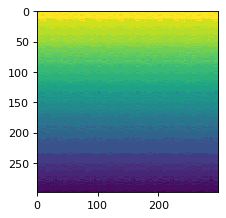

Segmento aproximado con spline lineal horizontal
Error = 16848.783546594692


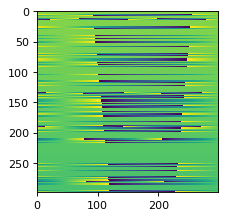

Segmento aproximado con spline lineal vertical
Error = 22050.937735162195


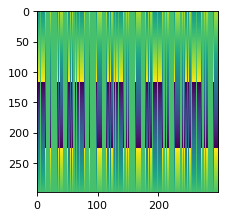

Segmento aproximado con spline lineal promedio
Error = 27662.100697524762


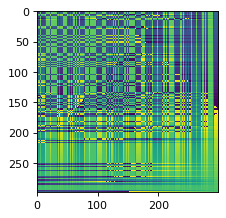

In [230]:
# test with h_gradient, top left hole

image = image_to_matrix("imagenes/h_gradient.png")
size=300
img_top_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=160, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Left imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()


Tamanio imagen (2000, 2400)
Segmento Top Right imagen gradiente horizontal a aproximar


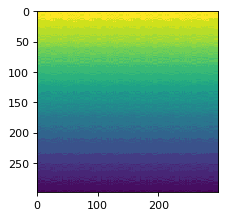

Segmento aproximado con spline lineal horizontal
Error = 17174.36476263387


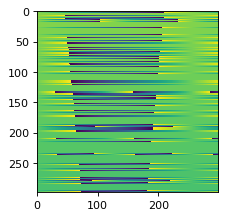

Segmento aproximado con spline lineal vertical
Error = 21937.517954408606


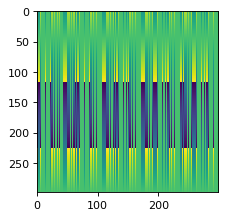

Segmento aproximado con spline lineal promedio
Error = 27631.982900255276


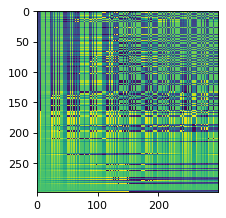

In [231]:
# test with h_gradient, top right hole

image = image_to_matrix("imagenes/h_gradient.png")
size=300
img_top_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Right imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Bottom Right imagen gradiente horizontal a aproximar


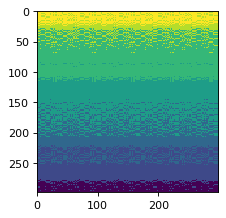

Segmento aproximado con spline lineal horizontal
Error = 12799.584680762107


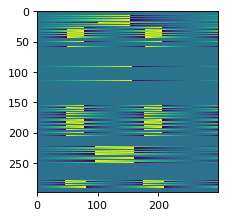

Segmento aproximado con spline lineal vertical
Error = 5898.468190979756


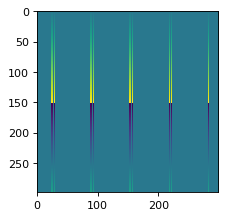

Segmento aproximado con spline lineal promedio
Error = 14733.129131314909


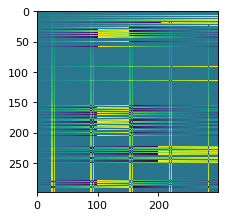

In [232]:
# test with h_gradient, bottom_right hole

image = image_to_matrix("imagenes/h_gradient.png")
size=300
img_bottom_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Right imagen gradiente horizontal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2400, 2000)
Segmento Bottom Left imagen gradiente vertical a aproximar


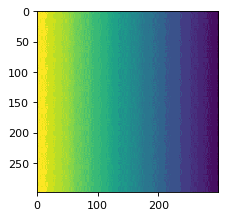

Segmento aproximado con spline lineal horizontal
Error = 22050.949730113665


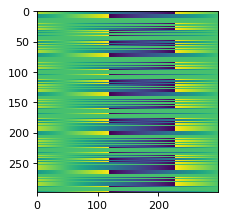

Segmento aproximado con spline lineal vertical
Error = 16836.804506794037


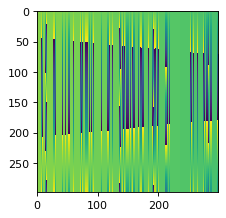

Segmento aproximado con spline lineal promedio
Error = 27619.144248147877


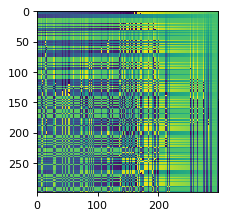

In [233]:
# test with v_gradiant, bottom left hole

image = image_to_matrix("imagenes/v_gradient.png")
size=300
img_bottom_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Left imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2400, 2000)
Segmento Top Left imagen gradiente vertical a aproximar


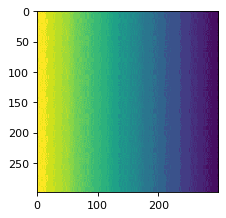

Segmento aproximado con spline lineal horizontal
Error = 21937.269497364527


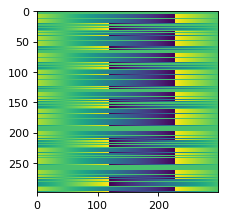

Segmento aproximado con spline lineal vertical
Error = 17187.275729445897


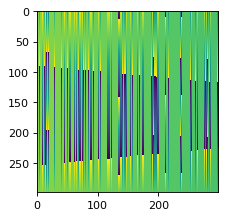

Segmento aproximado con spline lineal promedio
Error = 27598.1450282442


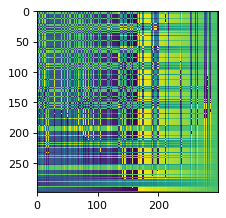

In [234]:
# test with v_gradient, top left hole

image = image_to_matrix("imagenes/v_gradient.png")
size=300
img_top_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=160, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Left imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2400, 2000)
Segmento Top Right imagen gradiente vertical a aproximar


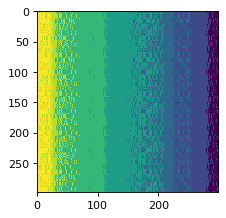

Segmento aproximado con spline lineal horizontal
Error = 5898.446490390499


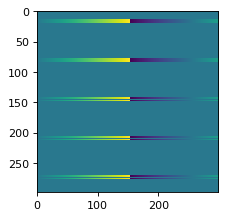

Segmento aproximado con spline lineal vertical
Error = 12820.291962354055


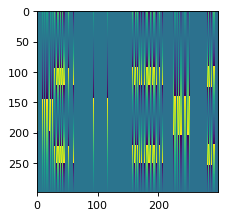

Segmento aproximado con spline lineal promedio
Error = 14767.25231720512


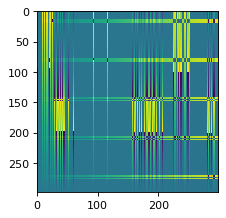

In [235]:
# test with v_gradient, top right hole

image = image_to_matrix("imagenes/v_gradient.png")
size=300
img_top_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Right imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2400, 2000)
Segmento Bottom Right imagen gradiente vertical a aproximar


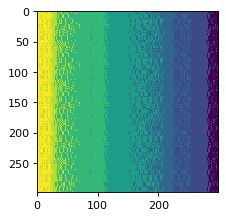

Segmento aproximado con spline lineal horizontal
Error = 5898.414024125468


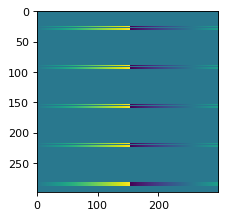

Segmento aproximado con spline lineal vertical
Error = 12392.475418575581


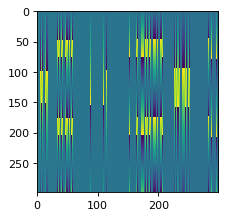

Segmento aproximado con spline lineal promedio
Error = 14432.010532146933


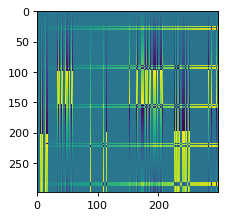

In [236]:
# test with v_gradient, bottom_right hole

image = image_to_matrix("imagenes/v_gradient.png")
size=300
img_bottom_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Right imagen gradiente vertical a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Bottom Left imagen gradiente diagonal a aproximar


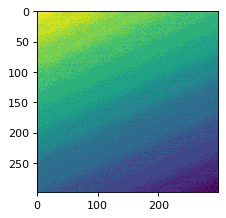

Segmento aproximado con spline lineal horizontal
Error = 13800.692953616495


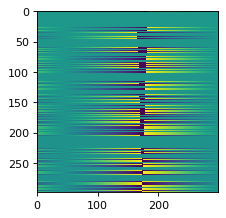

Segmento aproximado con spline lineal vertical
Error = 13294.336012001502


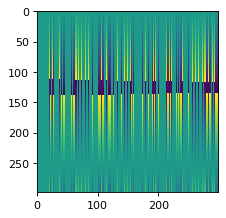

Segmento aproximado con spline lineal promedio
Error = 19187.537205175657


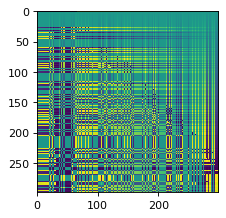

In [237]:
# test de d_gradient, bottom left hole

image = image_to_matrix("imagenes/d_gradient.png")
size=300
img_bottom_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=30, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Left imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_left_hole_app = fill_hole_bidirectional(img_bottom_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Top Left imagen gradiente diagonal a aproximar


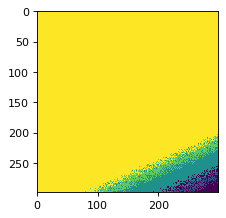

Segmento aproximado con spline lineal horizontal
Error = 10823.03067537


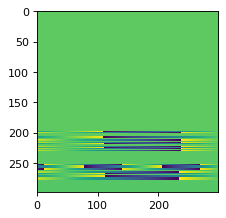

Segmento aproximado con spline lineal vertical
Error = 16585.76513158196


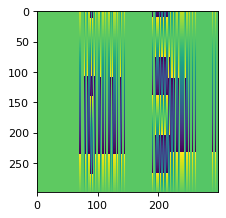

Segmento aproximado con spline lineal promedio
Error = 21941.340615377176


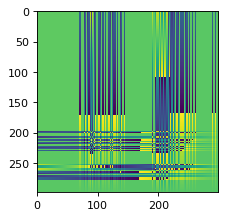

In [238]:
# test de d_gradient, top left hole

image = image_to_matrix("imagenes/d_gradient.png")
size=300
img_top_left_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=160, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Left imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_left_hole_app = fill_hole_bidirectional(img_top_left_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_left_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_left_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_left_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Top Right imagen gradiente diagonal a aproximar


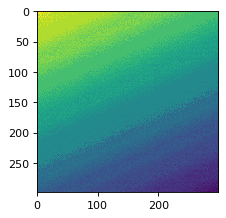

Segmento aproximado con spline lineal horizontal
Error = 12907.574171779917


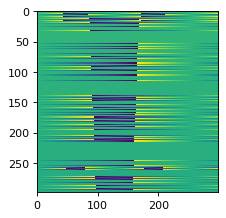

Segmento aproximado con spline lineal vertical
Error = 17335.04222665754


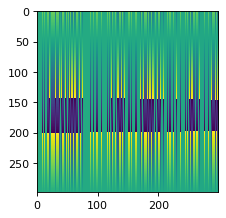

Segmento aproximado con spline lineal promedio
Error = 22190.40466057345


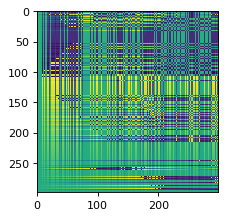

In [239]:
# test de d_gradient, top right hole

image = image_to_matrix("imagenes/d_gradient.png")
size=300
img_top_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=1, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Top Right imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_top_right_hole_app = fill_hole_bidirectional(img_top_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_top_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_top_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_top_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

Tamanio imagen (2000, 2400)
Segmento Bottom Right imagen gradiente diagonal a aproximar


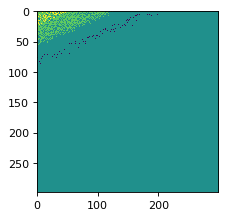

Segmento aproximado con spline lineal horizontal
Error = 6992.1349386292595


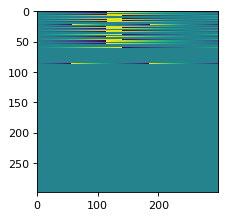

Segmento aproximado con spline lineal vertical
Error = 11739.277022031638


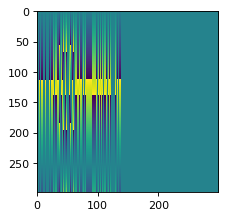

Segmento aproximado con spline lineal promedio
Error = 15969.899623980109


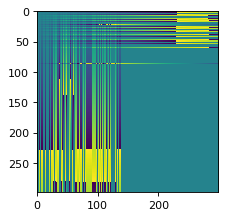

In [259]:
# test de d_gradient, bottom right hole

image = image_to_matrix("imagenes/d_gradient.png")
size=300
img_bottom_right_hole,x_hole,y_hole = make_a_hole(image, size=300, seed=99, case="corner")
img_subm = image[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_subm, "img_subm_temp.png")

print("Segmento Bottom Right imagen gradiente diagonal a aproximar")
figure(num=1, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
img_h_gradient = mpimg.imread('img_subm_temp.png')
imgplot = plt.imshow(img_h_gradient)
plt.show()

#... interpolation using fill_hole_bidirectional and analisis
# h
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'h')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal horizontal")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# v
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'v')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal vertical")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

# a
img_bottom_right_hole_app = fill_hole_bidirectional(img_bottom_right_hole, x_hole, y_hole, size, scp.interp1d, 'a')
img_app_subm = img_bottom_right_hole_app[x_hole:x_hole+size-1, y_hole:y_hole+size-1]
write_image(img_app_subm, "img_app_subm.png")
error_bottom_right_hole_app = error(img_subm,img_app_subm)

figure(num=2, figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
print("Segmento aproximado con spline lineal promedio")
print("Error = " + str(error_bottom_right_hole_app))
img_app = mpimg.imread('img_app_subm.png')
imgplot = plt.imshow(img_app)
plt.show()

### Análisis Cualitativo
En el caso de las imágenes que tienen agujeros en las esquinas, parece ser que la opción de extrapolar horizontal, vertical o promedial no resulta muy útil. Lo mejor sería, quizas, asignarle valores tentativos a los límites de las esquinas para poder realizar una interpolación (aunque con datos falsos). Una opción sería copiar los datos límites de una esquina opuesta, por ejemplo.

### 3. Caso general utilizando imagen real.

* Implemente la función `fill_any_hole` que rellene _missing values_ presentes en una imagen en cualquier posición (interior, en algún borde o esquina). 

In [244]:
'''
function to fill a hole on the image matrix. 

image: array representation of image
x_hole,y_hole: coordinates of the hole
size: size of the hole (>= 2)
interpolator: function for interpolation.
'''

def fill_any_hole(image, x_hole, y_hole, size, interpolator):
    height, width = image.shape
    # caso interior
    if(1<=x_hole<height-size and 1<=y_hole<width-size):
        return fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, 'a')
    
    # caso lado top y bottom
    elif((x_hole == 0 and 1<=y_hole<width-size) or (x_hole == height - size and 1<=y_hole<width-size)):
        return fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, 'h')
    
    # caso lado left y right
    elif((y_hole == 0 and 1<=x_hole<height-size) or (y_hole == width - size and 1<=x_hole<height-size)):
        return fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, 'v')
    
    # caso esquinas
    else: 
        return fill_hole_bidirectional(image, x_hole, y_hole, size, interpolator, 'a')
    


* Interpole y rellene _missing values_ ubicados en diversas posiciones en la imagen _ola.jpg_. Realice un análisis cualitativo y cuantitativo (graficando las imágenes y midiendo el error matricial respecto a la imagen sin _missing values_). Comente los resultados y concluya al respecto. 

Tamanio imagen (334, 500)
Imagen original


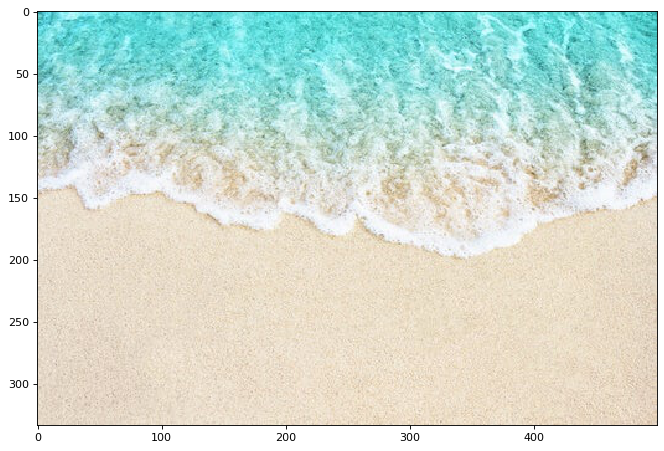

Imagen con center hole


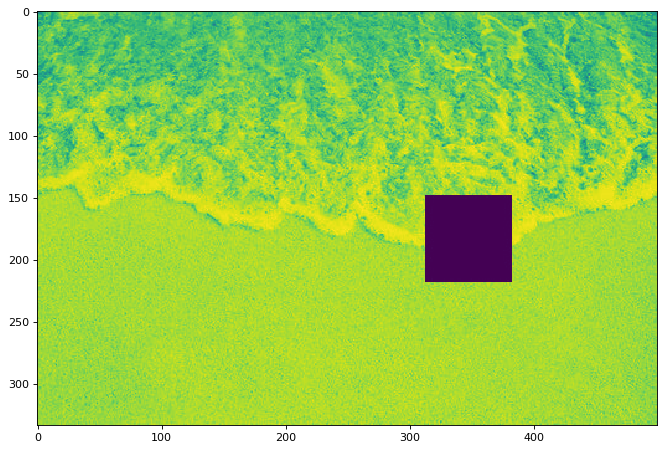

Aproximación de imagen con center hole
Error: 921.2306985766378


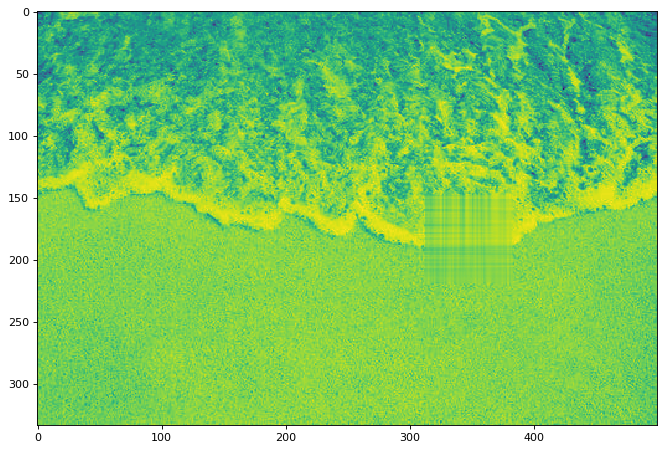

Imagen con border hole


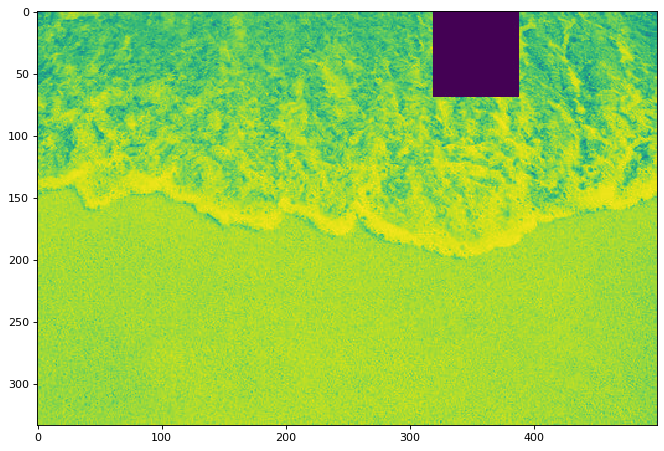

Aproximación de imagen con border hole
Error: 1870.517308126284


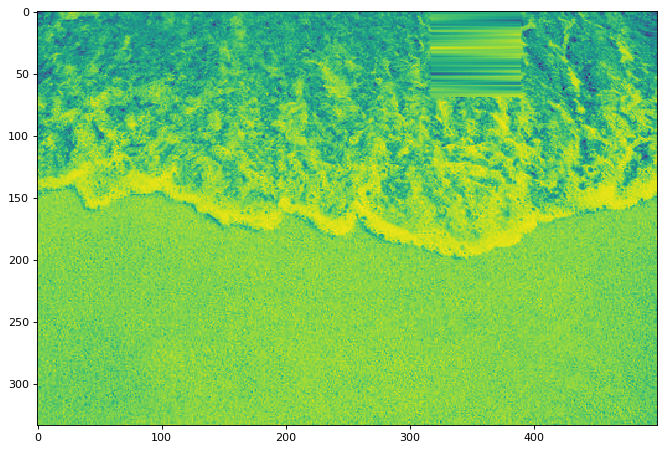

Imagen con corner hole


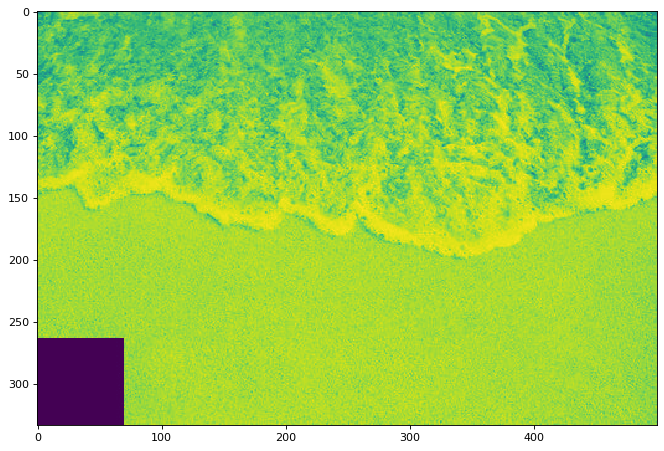

Aproximación de imagen con corner hole
Error: 8046.173003360044


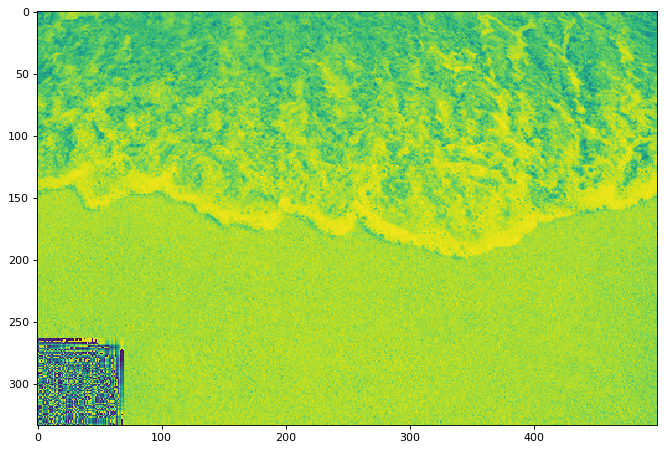

In [269]:
image = image_to_matrix("imagenes/ola.jpg")

print("Imagen original")
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img = mpimg.imread('imagenes/ola.jpg')
imgplot = plt.imshow(img)
plt.show()


img_center_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="center")
#... interpolation and analisis
write_image(img_center_hole, "img_center_hole.jpg")
img_subm = image[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
app_center_hole = fill_any_hole(img_center_hole, x_hole, y_hole, 70, scp.interp1d)
app_subm = app_center_hole[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
write_image(app_center_hole, "app_center_hole.jpg")
error_ch = error(img_subm,app_subm)

print("Imagen con center hole")
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('img_center_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()

print("Aproximación de imagen con center hole")
print("Error: " + str(error_ch))
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('app_center_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()


img_border_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="border")
#... interpolation and analisis
write_image(img_border_hole, "img_border_hole.jpg")
img_subm = image[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
app_border_hole = fill_any_hole(img_border_hole, x_hole, y_hole, 70, scp.interp1d)
app_subm = app_border_hole[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
write_image(app_border_hole, "app_border_hole.jpg")
error_bh = error(img_subm,app_subm)

print("Imagen con border hole")
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('img_border_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()

print("Aproximación de imagen con border hole")
print("Error: " + str(error_bh))
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('app_border_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()

img_corner_hole,x_hole,y_hole = make_a_hole(image, size=70, seed=30, case="corner")
#... interpolation and analisis
write_image(img_corner_hole, "img_corner_hole.jpg")
img_subm = image[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
app_corner_hole = fill_any_hole(img_corner_hole, x_hole, y_hole, 70, scp.interp1d)
app_subm = app_corner_hole[x_hole:x_hole+70-1, y_hole:y_hole+70-1]
write_image(app_corner_hole, "app_corner_hole.jpg")
error_coh = error(img_subm,app_subm)

print("Imagen con corner hole")
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('img_corner_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()

print("Aproximación de imagen con corner hole")
print("Error: " + str(error_coh))
figure(num=1, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
img_ch = mpimg.imread('app_corner_hole.jpg')
imgplot = plt.imshow(img_ch)
plt.show()

### Análisis Cualitativo y Comentarios
Como ya se ha dicho, lo mejor es escoger una opción de interpolación (horizontal, vertical, promedio) que no implique la necesidad de extrapolar datos. Lo mejor es utilizar una estrategia de interpolación que involucre el promedio entre la opción horizontal y vertical para imágenes cuyos pixeles no siguen una horientación específica. Lo mejor para los casos con agujeros en los límites debería ser asumir valores para los pixeles en los límites basándonos en la información presente en la misma imagen.

## Consideraciones Importantes

* Si bien se proveen los casos de prueba y las _seeds_ correspondientes, la revisión de la tarea puede ser realizada con otros casos de prueba y _seeds_ distintas, por lo que sus algoritmos deben funcionar para casos generales.

# Referencias
[1] Implementación de _scipy_ https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.KroghInterpolator.html#scipy.interpolate.KroghInterpolator

[2] Implementación de _scipy_ 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html

[3] Implementación de _scipy_ https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

[4] Manejo de imágenes con _matplotlib_ https://stackoverflow.com/questions/35286540/display-an-image-with-python 

[5] Manejo de imágenes con _matplotlib_ https://matplotlib.org/users/image_tutorial.html

[6] Norma de Frobenius en _numpy_ https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html


---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.